We conducted simulations of the orbits of the globular cluster NGC 6316 using five different masses for the Galactic disk `M_disk`. To gain a qualitative understanding of how the mass of the Galactic disk affects the orbits, let's first visualize the projections of these simulated orbits onto the Galactic disk:

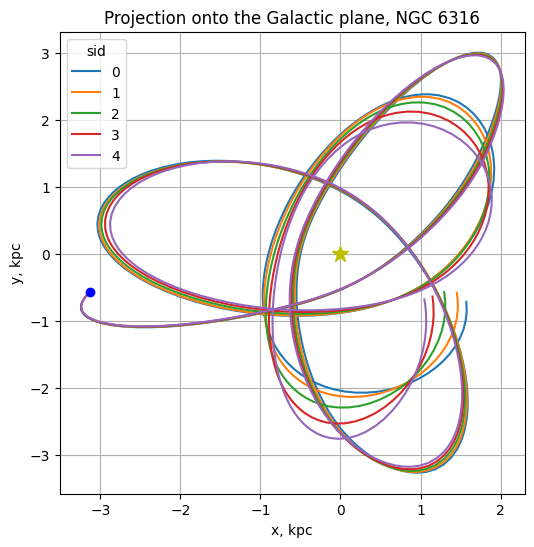

In [1]:
from citros_data_analysis import data_access as da
citros = da.CitrosDB(repo = 'gal_orbits')

# query data using citros_data_analysis package, get pandas.DataFrame
F = citros.batch('galactic orbits_1').topic('/gal_orbits').data(['data.data[0]', 'data.data[9]', 'data.data[10]'])

# change, calculate, explore your data - take full advantage of working with pandas python package
F.rename({'data.data[0]': 't', 'data.data[9]': 'xg', 'data.data[10]': 'yg'}, axis = 1, inplace = True)

# plot with citros_data_analysis
fig, ax = citros.plot_graph(F, 'xg', 'yg', '-', set_x_label='x, kpc', set_y_label='y, kpc', title='Projection onto the Galactic plane, NGC 6316')

# add additional information on the graph: position of the Sun and start of the simulation
ax.plot(0, 0, 'y*', markersize = 12)
ax.plot(F['xg'][F['sid']==0].iloc[0], F['yg'][F['sid']==0].iloc[0], 'bo')

Let's visualize the scatter of coordinates at the end of the simulation. The final point of each simulation run corresponds to t = 200 Myr. Using `pandas`, we can easily select coordinates corresponding to the maximum time value. Then, using `citros_data_analysis`, we can display these coordinates along with the mean and standard deviation ellipses:

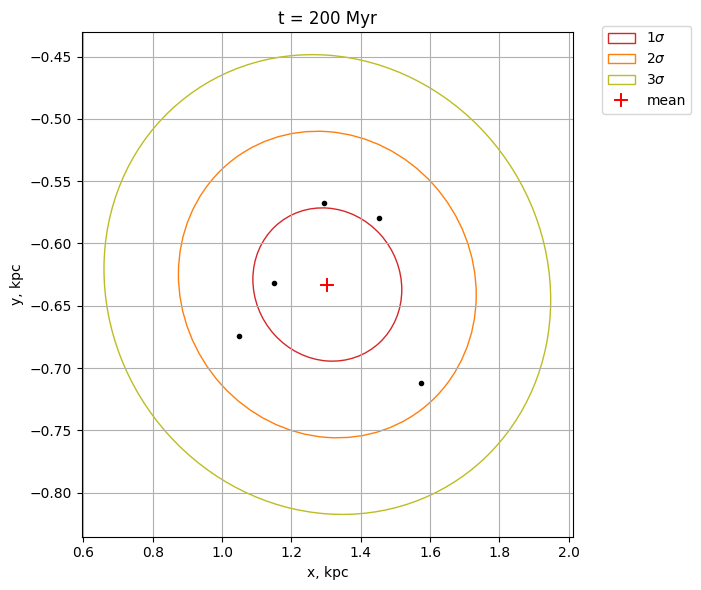

In [2]:
# for each simulation run select the last point (it corresponds to the maximum t)
f = F.loc[F.groupby('sid')['t'].idxmax()]

fig, ax = citros.plot_sigma_ellipse(f, 'xg', 'yg', n_std = [1,2,3], plot_origin=False, set_x_label= 'x, kpc', set_y_label= 'y, kpc', title = 't = 200 Myr')

We can also obtain a quantitative understanding of the extent to which the mass of the Galactic disk influences the cluster's orbits. For example, we can check whether the standard deviation of the distance `d` from the Galactic center calculated across different simulations does not exceed 15 percent of the overall average distance `d_mean`. The distance `d` from the Galactic center to the cluster can be calculated as the square root of the sum of the squared values in the 'R' ('data.data[1]') and 'z' ('data.data[5]') columns.

In [3]:
# query data
F = citros.batch('galactic orbits_1').topic('/gal_orbits').data(['data.data[0]', 'data.data[1]', 'data.data[5]'])
F.rename({'data.data[0]': 't', 'data.data[1]': 'R', 'data.data[5]': 'z'}, axis = 1, inplace = True)

import numpy as np
# calculate galactocentric distance
F['d'] = np.sqrt(F['R']**2 + F['z']**2)

To calculate the average distance from the Galactic center to the cluster, a simple mean of all data points from all simulations is insufficient due to unequal time intervals between points. Instead, we should first calculate the mean distance for each time point across simulations on an equidistant time scale, and then compute the overall mean distance.

Although the time range for all simulations is the same (0-20 Myr), the number of points and their corresponding time moments vary. Therefore, we need to establish a correspondence between the different simulations. This can be achieved using the `citros_data_analysis.error_analysis package`. To align the data from different simulations, we can divide the time into a certain number of intervals and assign indexes to these intervals. For each interval, we then calculate the mean distance for each simulation. This approach yields a common set of time values for all simulations, along with a corresponding set of distance values determined for these time points.

In [4]:
from citros_data_analysis import error_analysis as analysis
dataset = analysis.CitrosData(F, data_label=['d'], units = 'kpc')
db = dataset.bin_data(n_bins = 50, param_label = 't')

# calculate statistics among different simulations
stat = db.get_statistics(return_format='citrosStat')

# get the average distance
d_mean = stat.mean.mean()

Using the `citros_data_analysis.validation` package, we can check whether the standard deviation is not very significant and is less than 15 percent of the average distance from the Galactic center:

std_test: passed


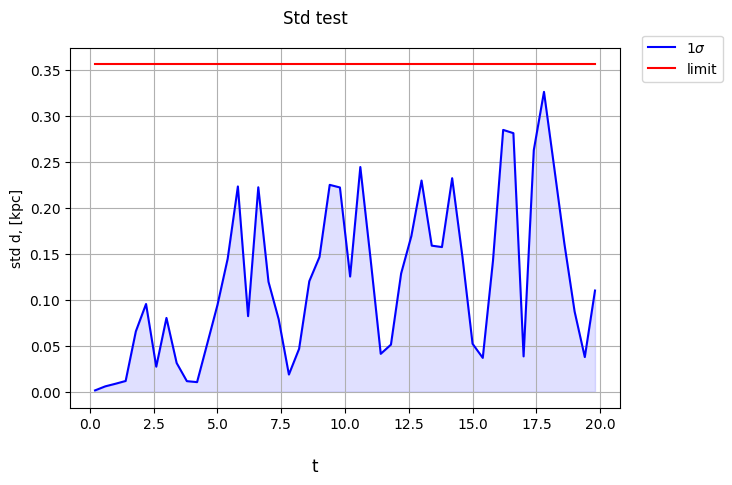

In [6]:
from citros_data_analysis import validation as va
V = va.Validation(F, data_label = 'd', param_label = 't', method = 'bin', num = 50, units = 'kpc')
log, table, fig = V.std_test(limits = d_mean*0.15, n_std = 1, nan_passed = True, std_area = True, std_color = 'b')